In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

In [6]:
d = {'win':[], 'fit_lam':[], 'do_viterbi':[], 
     'snr_before':[], 'distortion_before':[], 'length_before':[], 
     'snr':[], 'distortion':[], 'orig_length':[], 
     'path_filename':[],
     'length':[], 'elapsed':[]}

description = "Caltech-101 in GTzan"
fileprefix = "Caltech101GTzan"
keys = ['win', 'fit_lam', 'do_viterbi', 'snr_before', 'distortion_before', 'length_before', 'snr', 'distortion', 'length', 'elapsed']
filename = ""
orig_length = 0
files = glob.glob("../results/LowFreq_Final/*.txt")# + glob.glob("../results/LowFreq2/*.txt")
files = [f for f in files if not "3D" in f]
print(len(files))
for f in files:
    fin = open(f)
    for line in fin.readlines():
        fields = line.split()
        if len(fields) == 2:
            filename = fields[0]
            orig_length = float(fields[1])
        else:
            for key, f in zip(keys, fields):
                if f == 'False':
                    f = 0
                elif f == 'True':
                    f = 1
                else:
                    f = float(f)
                d[key].append(f)
            d['path_filename'].append(filename)
            d['orig_length'].append(orig_length)
    fin.close()
for key in d:
    d[key] = np.array(d[key])

1000


In [7]:
for key in ['snr', 'length', 'distortion']:
    key2 = "{}_diff".format(key)
    d[key2] = np.zeros(len(d[key]))
    d[key2][0::2] = d[key][1::2]-d[key][0::2]
    d[key2][1::2] = d[key2][0::2]
d['length_ratio'] =  d['length']/d['orig_length']

In [8]:
df = pd.DataFrame(data=d)
fit_lams = np.unique(df[['fit_lam']])
print(fit_lams)
wins = np.unique(df[['win']])
wins = np.array(wins, dtype=int)

c = plt.cm.Accent
palette = {0.1:0.8*np.array(list(c.colors[0])),
          1.0:0.95*np.array(list(c.colors[1])),
          10.0:np.minimum(1, np.array(list(c.colors[2]))*1.1),
          np.inf:np.array(list(c.colors[3]))}

[ 0.1  1.  10. ]


# Viterbi Distortion

In [ ]:
c = plt.cm.Accent
fit_lam_palette = {0.1:0.8*np.array(list(c.colors[0])),
          1.0:0.95*np.array(list(c.colors[1])),
          10.0:np.minimum(1, np.array(list(c.colors[2]))*1.1),
          np.inf:np.array(list(c.colors[3]))}
df2 = df.loc[df['win'] == 16]
fac = 0.65
plt.figure(figsize=(fac*18, fac*3))
win = 16
plt.subplot(121)
sns.histplot(df2, x="distortion_diff", hue="fit_lam", palette=palette, element="step", fill=False)
plt.title("{} Distortion Difference, $\ell$={}".format(description, win))
legend = []
key_str = {0.1:"0.1  ", 1:"1.0  ", 10:"10.0"}
for fit_lam in fit_lams:
    mu = np.median(df2.loc[df2['fit_lam'] == fit_lam]['distortion_diff'])
    sgn = " -"
    if mu > 0:
        sgn = "+"
    legend.append("$\\lambda=${} (Med {}{:.3f})".format(key_str[fit_lam], sgn, np.abs(mu)))
plt.legend(legend[::-1])
plt.xlabel("Distortion Using Viterbi - Distortion Not Using Viterbi")
plt.ylabel("Counts")

plt.subplot(122)
sns.histplot(df2, x="snr_diff", hue="fit_lam", palette=palette, element="step", fill=False)
plt.title("{} in GTzan SNR Difference, $\ell$={}".format(description, win))
legend = []
for fit_lam in fit_lams:
    mu = np.median(df2.loc[df2['fit_lam'] == fit_lam]['snr_diff'])
    sgn = " -"
    if mu > 0:
        sgn = "+"
    legend.append("$\\lambda=${} (Med {}{:.3f} dB)".format(key_str[fit_lam], sgn, np.abs(mu)))
plt.legend(legend[::-1])
plt.xlabel("SNR (dB) Using Viterbi - SNR (dB) Not Using Viterbi")
plt.ylabel("Counts")
plt.savefig("{}ViterbiExperiment.svg".format(fileprefix), bbox_inches='tight')

# Fixing Lambda, Varying Window

In [ ]:
lam = 0.1
df2 = df.loc[(df['fit_lam'] == lam)*(df['do_viterbi'] == 1)]
c = plt.cm.Accent

fac = 0.65
plt.figure(figsize=(fac*22, fac*4))
win = 16
plt.subplot(121)
sns.histplot(df2, x="distortion", hue="win", element="step", fill=False, binrange=[0, 0.3], binwidth=0.001)
plt.title("{} Distortion vs Window Length $\ell$, $\\lambda$={}".format(description, lam))
legend = []
for win in wins:
    mu = np.median(df2.loc[df2['win'] == win]['distortion'])
    sp = ""
    if win < 10:
        sp = "  "
    legend.append("$\\ell$={}{} (Med {:.3f})".format(win, sp, np.abs(mu)))
plt.legend(legend[::-1])
plt.xlabel("Distortion")
plt.ylabel("Counts")

plt.subplot(122)
sns.histplot(df2, x="snr", hue="win", element="step", fill=False)
plt.title("{} SNR vs Window Length $\ell$, $\\lambda$={}".format(description, lam))
legend = []
for win in wins:
    mu = np.median(df2.loc[df2['win'] == win]['snr'])
    sp = ""
    if win < 10:
        sp = "  "
    legend.append("$\\ell$={}{} (Med {:.2f} dB)".format(win, sp, np.abs(mu)))
plt.legend(legend[::-1])
plt.xlabel("SNR (dB)")
plt.ylabel("Counts")
plt.savefig("{}FixedLam.svg".format(fileprefix), bbox_inches='tight')

# Fixing Window, Varying Lambda

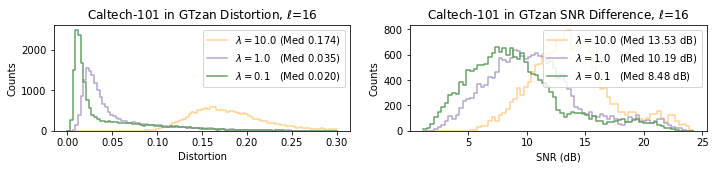

In [9]:
df = pd.DataFrame(data=d)
win = 16
df2 = df.loc[(df['win'] == win)*(df['do_viterbi'] == 1)]
c = plt.cm.Accent
fit_lam_palette = {0.1:0.8*np.array(list(c.colors[0])),
          1.0:0.95*np.array(list(c.colors[1])),
          10.0:np.minimum(1, np.array(list(c.colors[2]))*1.1),
          np.inf:np.array(list(c.colors[3]))}
df2 = df.loc[df['win'] == 16]
fac = 0.65
plt.figure(figsize=(fac*18, fac*3))
win = 16
plt.subplot(121)
sns.histplot(df2, x="distortion", hue="fit_lam", palette=palette, element="step", binwidth=0.003, binrange=[0, 0.3], fill=False)
plt.title("{} Distortion, $\ell$={}".format(description, win))
legend = []
key_str = {0.1:"0.1  ", 1:"1.0  ", 10:"10.0"}
for fit_lam in fit_lams:
    mu = np.median(df2.loc[df2['fit_lam'] == fit_lam]['distortion'])
    legend.append("$\\lambda=${} (Med {:.3f})".format(key_str[fit_lam], mu))
plt.legend(legend[::-1])
plt.xlabel("Distortion")
plt.ylabel("Counts")

plt.subplot(122)
sns.histplot(df2, x="snr", hue="fit_lam", palette=palette, element="step", fill=False)
plt.title("{} SNR Difference, $\ell$={}".format(description, win))
legend = []
for fit_lam in fit_lams:
    mu = np.median(df2.loc[df2['fit_lam'] == fit_lam]['snr'])
    legend.append("$\\lambda=${} (Med {:.2f} dB)".format(key_str[fit_lam], mu))
plt.legend(legend[::-1])
plt.xlabel("SNR (dB)")
plt.ylabel("Counts")
plt.savefig("{}FixedWin.svg".format(fileprefix), bbox_inches='tight')

# Shift Recovery Experiment

In [10]:
import json
description = "2D Caltech-101 in GTzan"
fileprefix = "CaltechGTzan"
keys = ['fit_lam', 'distortion', 'snr', 'length', 'gt_shift', 'recovered_shift', 'recovered_distortion']
d = {k:[] for k in keys}
filename = ""
orig_length = 0
files = glob.glob("../results/ShiftExperiment/*.json")
print(len(files))
for f in files:
    fields = json.load(open(f))
    for key in fields:
        if key in keys:
            d[key] += fields[key]

1000


40.01000000000204
0.9296388888888889


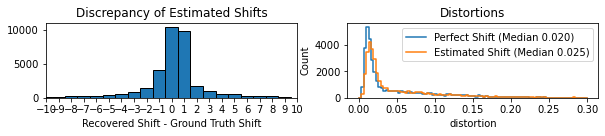

In [12]:
df = pd.DataFrame(data=d)
df = df.loc[(df['fit_lam'] == 0.1)]
diff = df['recovered_shift']-df['gt_shift']
print(np.quantile(diff, 0.99))
fac = 0.55
plt.figure(figsize=(fac*18, fac*2.5))

plt.subplot(121)
plt.hist(diff, bins=np.arange(-10, 11)-0.5, edgecolor='k')
plt.xlim([-10, 10])
print(np.sum(np.abs(diff) < 10)/diff.size)
plt.gca().set_xticks(np.arange(-10, 11, 1))
plt.xlabel("Recovered Shift - Ground Truth Shift")
plt.title("Discrepancy of Estimated Shifts")

plt.subplot(122)
sns.histplot(df, x="distortion", element="step", fill=False, binrange=[0, 0.3])
sns.histplot(df, x="recovered_distortion", element="step", fill=False, binrange=[0, 0.3])
plt.legend(["Perfect Shift (Median {:.3f})".format(np.median(df['distortion'])), 
            "Estimated Shift (Median {:.3f})".format(np.median(df['recovered_distortion'])) ])
plt.title("Distortions")

plt.savefig("ShiftsExperiment.svg", bbox_inches='tight')